# Overview
This notebook represents my submission for the task on "[The World's Biggest Companies 2021](https://www.kaggle.com/berkayalan/the-worlds-biggest-companies-2021)" dataset. The description of the task is simply:
> Create an EDA and show breakdowns of companies

The [original source](https://www.forbes.com/lists/global2000/#242cc9bb5ac0) of the dataset is from Forbes, which ranks each of the companies according to the following equally-weighted metrics:
- Sales
- Profit
- Assets
- Market Value

Let's dive in!

# Imports & Settings

In [1]:
# Standard imports
import numpy as np
import pandas as pd

# Visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sns.set_theme(style='darkgrid')

# Preprocessing
## Previewing Data

In [3]:
df = pd.read_csv('data.csv', delimiter=';')
df.tail()

,Rank,Name,Country,Sales,Profit,Assets,Market Value
495,496,CSL,Australia,$9.9 B,$2.6 B,$17.7 B,$94.7 B
496,497,Safran,France,$19 B,$401.3 M,$48.4 B,$66.8 B
497,498,Banorte,Mexico,$9.4 B,$1.4 B,$89.7 B,$17.6 B
498,498,KeyCorp,United States,$7.3 B,$1.3 B,$170.3 B,$20 B
499,500,Lufax Holding,China,$8.3 B,$1.8 B,$38.1 B,$34 B


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Rank          500 non-null    int64 
 1   Name          500 non-null    object
 2   Country       500 non-null    object
 3   Sales         500 non-null    object
 4   Profit        500 non-null    object
 5   Assets        500 non-null    object
 6   Market Value  500 non-null    object
dtypes: int64(1), object(6)
memory usage: 27.5+ KB


In [5]:
df.isna().sum()

Rank            0
Name            0
Country         0
Sales           0
Profit          0
Assets          0
Market Value    0
dtype: int64

## Setting Index to Rank

In [6]:
df.set_index('Rank', inplace=True)
df.head()

,Name,Country,Sales,Profit,Assets,Market Value
Rank,,,,,,
1,ICBC,China,$190.5 B,$45.8 B,"$4,914.7 B",$249.5 B
2,JPMorgan Chase,United States,$136.2 B,$40.4 B,"$3,689.3 B",$464.8 B
3,Berkshire Hathaway,United States,$245.5 B,$42.5 B,$873.7 B,$624.4 B
4,China Construction Bank,China,$173.5 B,$39.3 B,"$4,301.7 B",$210.4 B
5,Saudi Arabian Oil Company (Saudi Aramco),Saudi Arabia,$229.7 B,$49.3 B,$510.3 B,"$1,897.2 B"


## Converting to Floats
The `Sales`, `Profit`, `Assets`, and `Market Value` columns are all currently stored as strings and need to be converted to floats. I will keep the units in billions of dollars to ease the visualization process (axis formatting can be a pain).

In [7]:
def converter(x):
    converted = float(x[1:-2].replace(',', ''))
    if x.endswith('M'):
        converted /= 1000
    return converted

In [8]:
for col in df.columns[2:]:
    df[col] = df[col].apply(converter)

In [9]:
df.head()

,Name,Country,Sales,Profit,Assets,Market Value
Rank,,,,,,
1,ICBC,China,190.5,45.8,4914.7,249.5
2,JPMorgan Chase,United States,136.2,40.4,3689.3,464.8
3,Berkshire Hathaway,United States,245.5,42.5,873.7,624.4
4,China Construction Bank,China,173.5,39.3,4301.7,210.4
5,Saudi Arabian Oil Company (Saudi Aramco),Saudi Arabia,229.7,49.3,510.3,1897.2


In [10]:
df.info(0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1 to 500
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          500 non-null    object 
 1   Country       500 non-null    object 
 2   Sales         500 non-null    float64
 3   Profit        500 non-null    float64
 4   Assets        500 non-null    float64
 5   Market Value  500 non-null    float64
dtypes: float64(4), object(2)
memory usage: 27.3+ KB


# EDA
## Number of Companies per Country

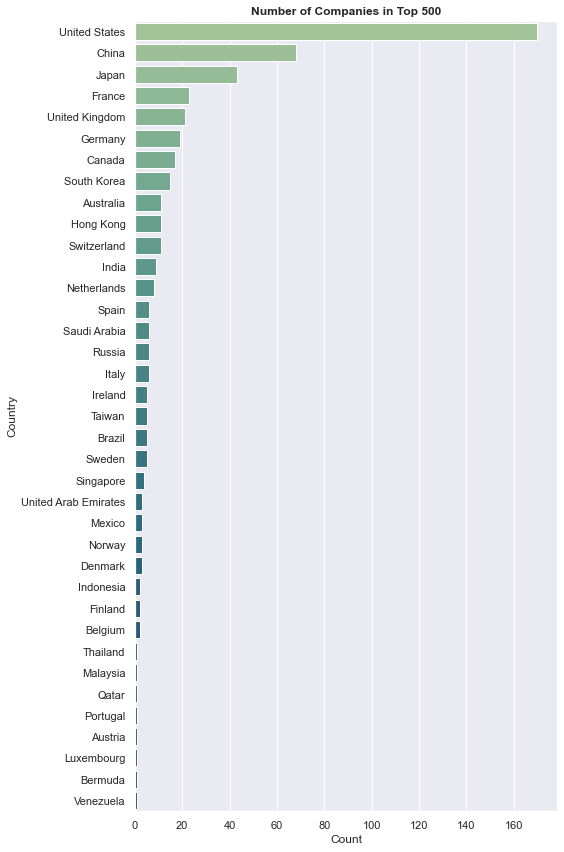

In [61]:
df_by_country = df[['Country', 'Name']].groupby('Country').count()
df_by_country.rename(columns={'Name': 'Count'}, inplace=True)
df_by_country.sort_values('Count', ascending=False, inplace=True)

fig = plt.figure(figsize=(8, 12))
sns.barplot(data=df_by_country, 
            x='Count', 
            y=df_by_country.index,
            orient='h',
            palette='crest')
plt.title('Number of Companies in Top 500', fontweight='bold')
plt.tight_layout();

## Average Metrics by Country

In [44]:
def plot_avg_metric(metric, ax=None):
    df_grouped = df.groupby('Country').mean()
    df_grouped.sort_values(metric, ascending=False, inplace=True)
    sns.barplot(data=df_grouped,
                x=metric,
                y=df_grouped.index,
                orient='h',
                palette='crest',
                ax=ax)
    ax.set_title(f'Average {metric} by Country', fontweight='bold')
    ax.set_xlabel(f'Average {metric} ($ billions)')
    plt.tight_layout(pad=1.50)

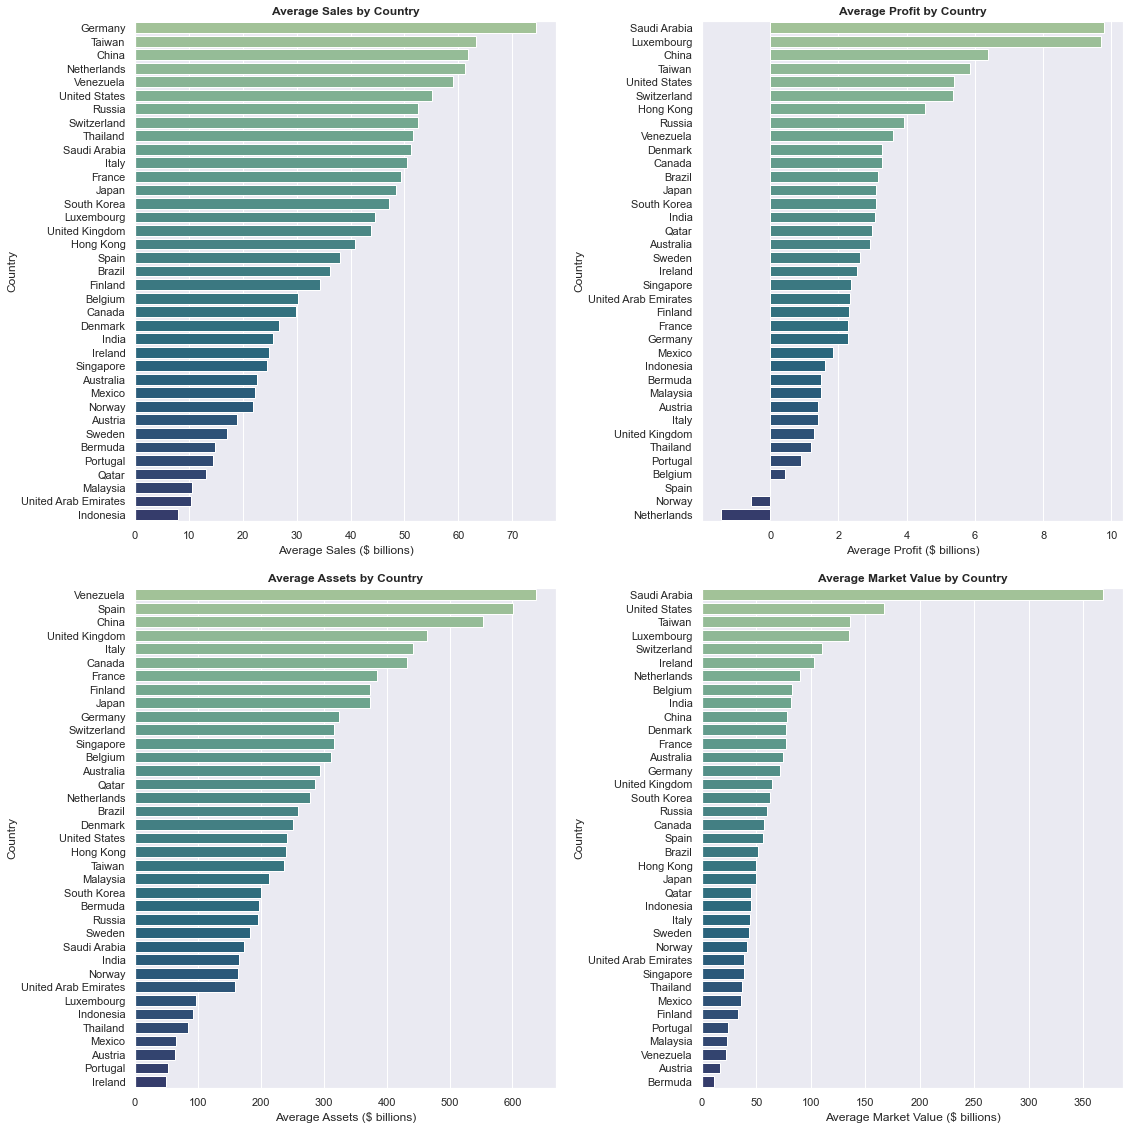

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
axes = np.reshape(axes, -1)

metrics = df.columns[2:]
for i, metric in enumerate(metrics):
    plot_avg_metric(metric, ax=axes[i])

## Market Value Ratios by Country

In [58]:
def market_value_ratio(metric, aggregator):
    df_ratio = df.copy()
    df_ratio[f'MVto{metric}'] = df_ratio['Market Value'] / df_ratio[metric]
    df_ratio = df_ratio.groupby('Country').agg(aggregator)
    df_ratio.sort_values(f'MVto{metric}', ascending=False, inplace=True)
    sns.barplot(data=df_ratio,
                x=f'MVto{metric}',
                y=df_ratio.index,
                orient='h',
                palette='crest')
    plt.title(f'{aggregator.title()} Market Value to {metric} Ratio', fontweight='bold')
    plt.xlabel('Ratio')

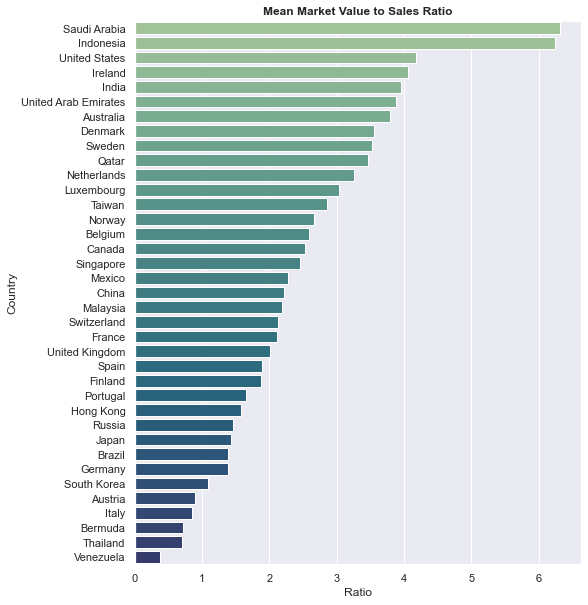

In [59]:
fig = plt.figure(figsize=(8, 10))
market_value_ratio('Sales', 'mean')

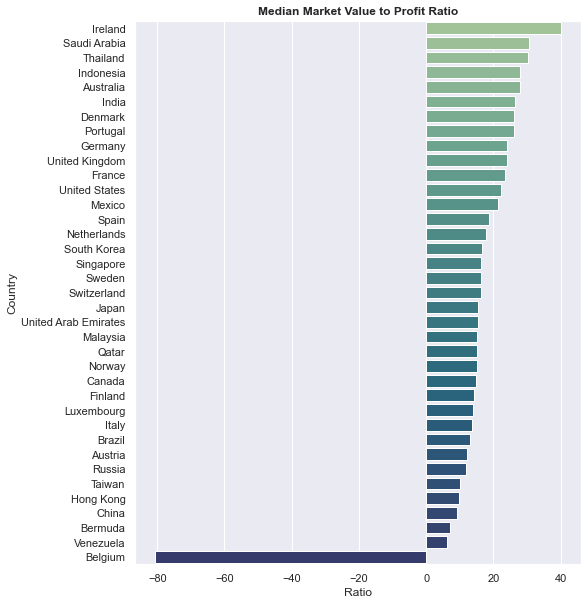

In [60]:
fig = plt.figure(figsize=(8, 10))
market_value_ratio('Profit', 'median')